In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [2]:
pd.set_option('display.max_columns', 150)

In [3]:
df_arc = pd.read_csv('data/data_arc.csv', parse_dates = [1,2])
df_bulk = pd.read_csv('data/data_bulk.csv')
df_bulk_time = pd.read_csv('data/data_bulk_time.csv', parse_dates = list(range(1,16)))
df_gas = pd.read_csv('data/data_gas.csv')
df_temp = pd.read_csv('data/data_temp.csv', parse_dates=[1])
df_wire = pd.read_csv('data/data_wire.csv')
df_wire_time = pd.read_csv('data/data_wire_time.csv', parse_dates = list(range(1,10)))

## Первичный анализ данных

#### Данные об электродах

In [4]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [5]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [6]:
df_arc.duplicated().sum()

0

Дубликатов не обнаружено, пропусков не обнаружено, можно работать дальше

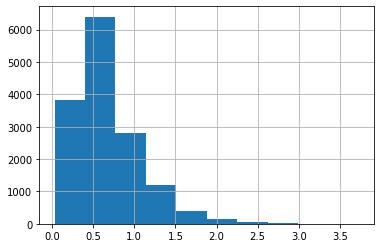

In [7]:
df_arc['Активная мощность'].hist()

In [8]:
df_arc['Активная мощность'].agg(['max', 'min'])

max    3.731596
min    0.030002
Name: Активная мощность, dtype: float64

Выбросов в столбце активной мощности не замечено. Значения находятся в диапазоне от 0.03 до 3.73. Наиболее частое значение в районе 0.6.

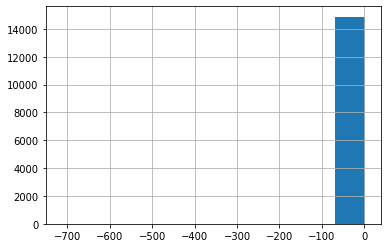

In [9]:
df_arc['Реактивная мощность'].hist()

In [10]:
df_arc['Реактивная мощность'].agg(['max', 'min'])

max      2.676388
min   -715.504924
Name: Реактивная мощность, dtype: float64

In [11]:
df_arc['Реактивная мощность'].replace(df_arc['Реактивная мощность'].min(),
                                      df_arc['Реактивная мощность'].median(), inplace=True)

In [12]:
df_arc['Реактивная мощность'].agg(['max', 'min'])

max    2.676388
min    0.020806
Name: Реактивная мощность, dtype: float64

In [13]:
(df_arc['Реактивная мощность'] < 0).value_counts()

False    14876
Name: Реактивная мощность, dtype: int64

Значение в -715 явно внесено ошибочно, заменяю его на медиану.

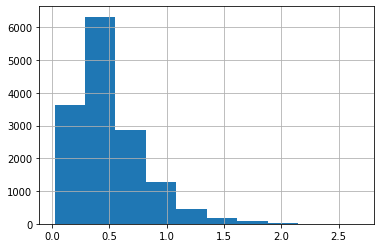

In [14]:
(df_arc['Реактивная мощность'][df_arc['Реактивная мощность'] > 0]).hist()

In [15]:
(df_arc['Реактивная мощность'][df_arc['Реактивная мощность'] > 0]).agg(['max', 'min'])

max    2.676388
min    0.020806
Name: Реактивная мощность, dtype: float64

Значения реактивной мощности находятся в диапазоне от 0.02 до 2.67. Наиболее частое значение в районе 0.4

In [16]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [17]:
df_arc['key'].is_monotonic

True

Ключи распределены последовательно.

In [18]:
df_arc[['Начало нагрева дугой', 'Конец нагрева дугой']].agg(['min', 'max'])

,Начало нагрева дугой,Конец нагрева дугой
min,2019-05-03 11:02:14,2019-05-03 11:06:02
max,2019-09-01 04:34:47,2019-09-01 04:36:08


Выбросов по дате нет. Время конца нагрева больше времени начала.

#### Данные о подаче сыпучих материалов (объем)

In [19]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [20]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Bulk 1


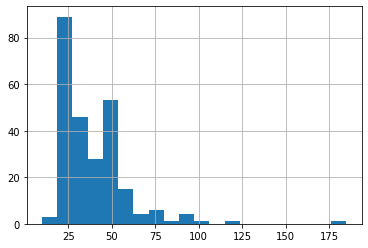

min     10.0
max    185.0
Name: Bulk 1, dtype: float64
------------
Bulk 2


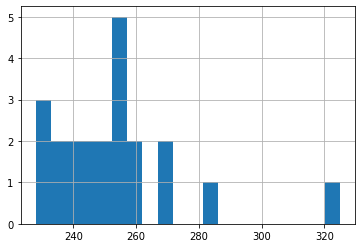

min    228.0
max    325.0
Name: Bulk 2, dtype: float64
------------
Bulk 3


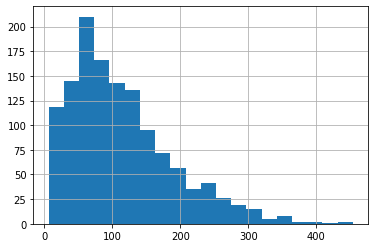

min      6.0
max    454.0
Name: Bulk 3, dtype: float64
------------
Bulk 4


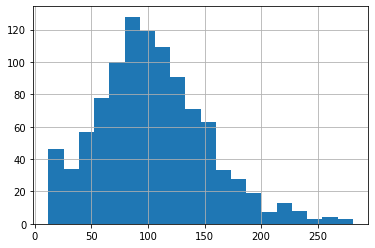

min     12.0
max    281.0
Name: Bulk 4, dtype: float64
------------
Bulk 5


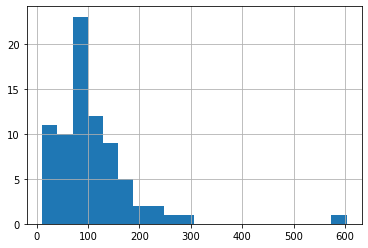

min     11.0
max    603.0
Name: Bulk 5, dtype: float64
------------
Bulk 6


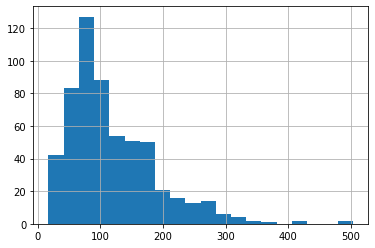

min     17.0
max    503.0
Name: Bulk 6, dtype: float64
------------
Bulk 7


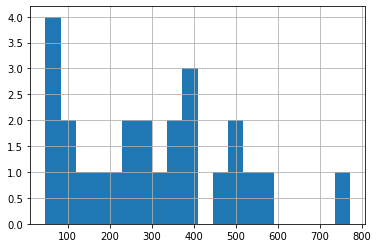

min     47.0
max    772.0
Name: Bulk 7, dtype: float64
------------
Bulk 8


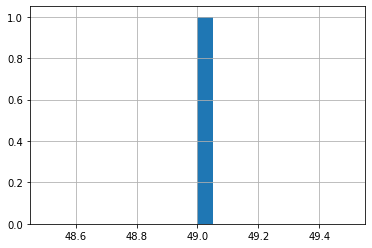

min    49.0
max    49.0
Name: Bulk 8, dtype: float64
------------
Bulk 9


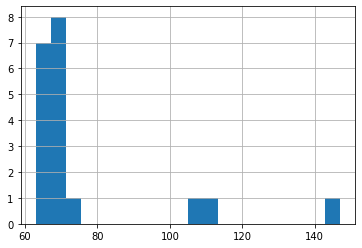

min     63.0
max    147.0
Name: Bulk 9, dtype: float64
------------
Bulk 10


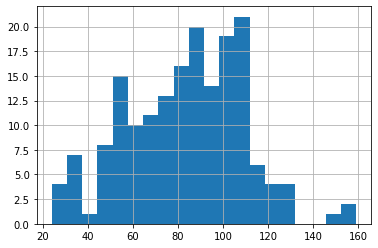

min     24.0
max    159.0
Name: Bulk 10, dtype: float64
------------
Bulk 11


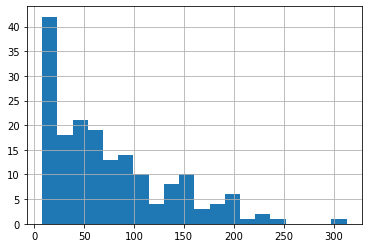

min      8.0
max    313.0
Name: Bulk 11, dtype: float64
------------
Bulk 12


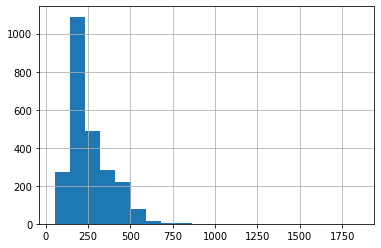

min      53.0
max    1849.0
Name: Bulk 12, dtype: float64
------------
Bulk 13


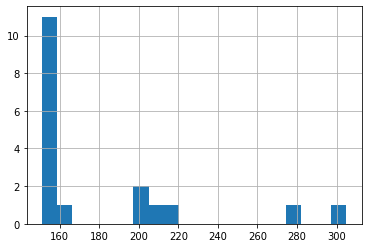

min    151.0
max    305.0
Name: Bulk 13, dtype: float64
------------
Bulk 14


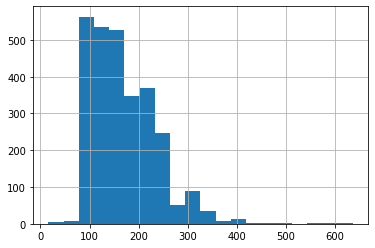

min     16.0
max    636.0
Name: Bulk 14, dtype: float64
------------
Bulk 15


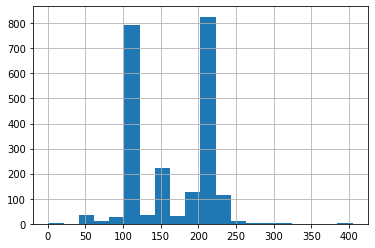

min      1.0
max    405.0
Name: Bulk 15, dtype: float64
------------


In [21]:
for bulk in df_bulk.columns[df_bulk.columns != 'key']:
    print(bulk)
    df_bulk[f'{bulk}'].hist(bins=20)
    plt.show()
    print(df_bulk[f'{bulk}'].agg(['min', 'max']))
    print('------------')

In [22]:
df_bulk['Bulk 8'].value_counts()

49.0    1
Name: Bulk 8, dtype: int64

In [23]:
df_bulk['Bulk 12'][df_bulk['Bulk 12'] > 1000]

303    1849.0
Name: Bulk 12, dtype: float64

В целом из 15 подач есть 2 подозрительных:
- восьмая имеет только одну подачу за все время;
- двенадцатая имеет очень большой выброс в 1849

In [24]:
df_bulk['key'].is_monotonic

True

Ключи идут последовательно.

#### Данные о подаче сыпучих материалов (время)

In [25]:
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56


In [26]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [27]:
df_bulk_time.isna().isin(df_bulk.isna()).sum()

key        3129
Bulk 1     3129
Bulk 2     3129
Bulk 3     3129
Bulk 4     3129
Bulk 5     3129
Bulk 6     3129
Bulk 7     3129
Bulk 8     3129
Bulk 9     3129
Bulk 10    3129
Bulk 11    3129
Bulk 12    3129
Bulk 13    3129
Bulk 14    3129
Bulk 15    3129
dtype: int64

Датафреймы по подачам и по времени подачи совпадают.

In [28]:
df_bulk_time.agg(['min', 'max'])

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
min,1,2019-05-03 17:50:19,2019-05-07 08:36:19,2019-05-03 20:13:36,2019-05-03 11:21:30,2019-05-07 08:36:19,2019-05-03 18:52:57,2019-05-07 11:37:42,2019-07-05 17:46:11,2019-05-14 00:04:56,2019-05-06 01:36:24,2019-05-05 16:45:05,2019-05-03 11:03:52,2019-05-05 00:39:35,2019-05-03 11:03:52,2019-05-03 11:03:52
max,3241,2019-08-30 23:01:32,2019-08-08 17:34:38,2019-08-31 23:39:11,2019-08-30 17:36:30,2019-08-28 09:01:08,2019-09-01 03:12:40,2019-08-31 07:22:25,2019-07-05 17:46:11,2019-08-11 15:09:33,2019-08-30 01:30:42,2019-08-31 16:00:49,2019-09-01 01:39:41,2019-08-26 20:31:16,2019-09-01 04:05:34,2019-09-01 04:05:34


Выбросов по датам не замечено.

#### Данные о продувке сплава газом

In [29]:
df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [30]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Пропусков нет.

In [31]:
df_gas['key'].is_monotonic

True

Ключи идут последовательно.

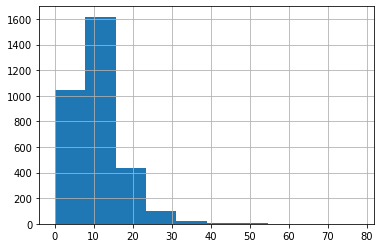

In [32]:
df_gas['Газ 1'].hist()

In [33]:
df_gas['Газ 1'][df_gas['Газ 1'] > 50]

116     50.581035
277     60.935689
319     77.995040
2107    52.142373
2567    51.380229
Name: Газ 1, dtype: float64

Выбросов не обнаружено.

#### Результаты измерения температуры

In [34]:
df_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [35]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


Есть пропуски в значениях температуры.

In [36]:
df_temp['key'].is_monotonic

True

Ключи идут последовательно

In [37]:
df_temp.duplicated().sum()

0

Дубликатов не обнаружено.

In [38]:
df_temp[['Время замера', 'Температура']].agg(['min','max'])

,Время замера,Температура
min,2019-05-03 11:16:18,1191.0
max,2019-09-01 04:38:08,1705.0


В столбце времени аномалий не замечено.

In [39]:
df_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


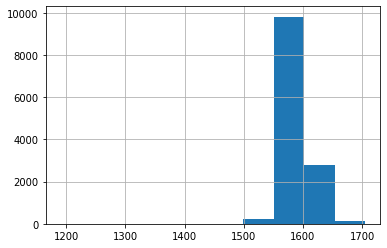

In [40]:
df_temp['Температура'].hist()

In [41]:
(df_temp['Температура'][df_temp['Температура'] < 1400]).value_counts()

1383.0    2
1204.0    1
1227.0    1
1218.0    1
1208.0    1
1191.0    1
Name: Температура, dtype: int64

В столбце температуры аномалий не замечено

#### Данные о проволочных материалах (объём)

In [42]:
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Wire 1


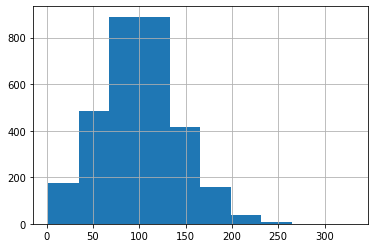

min      1.918800
max    330.314424
Name: Wire 1, dtype: float64
------------
Wire 2


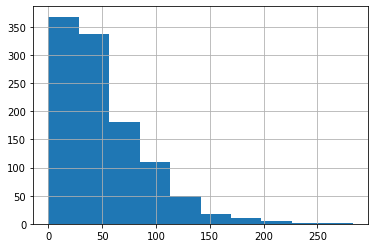

min      0.030160
max    282.780152
Name: Wire 2, dtype: float64
------------
Wire 3


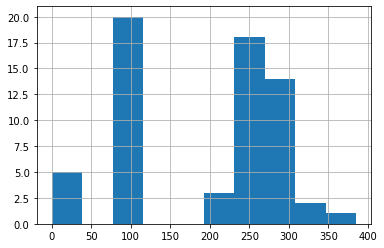

min      0.144144
max    385.008668
Name: Wire 3, dtype: float64
------------
Wire 4


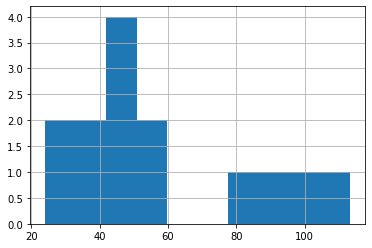

min     24.148801
max    113.231044
Name: Wire 4, dtype: float64
------------
Wire 5


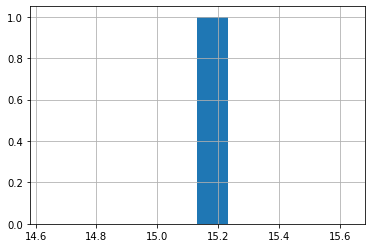

min    15.132
max    15.132
Name: Wire 5, dtype: float64
------------
Wire 6


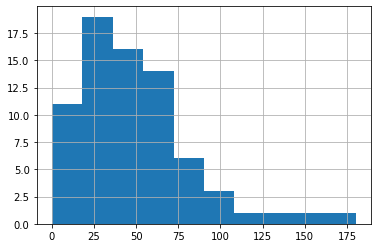

min      0.034320
max    180.454575
Name: Wire 6, dtype: float64
------------
Wire 7


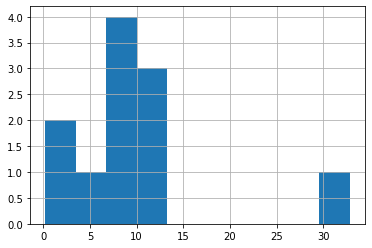

min     0.234208
max    32.847674
Name: Wire 7, dtype: float64
------------
Wire 8


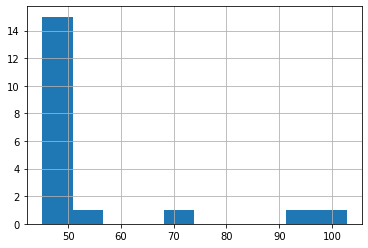

min     45.076721
max    102.762401
Name: Wire 8, dtype: float64
------------
Wire 9


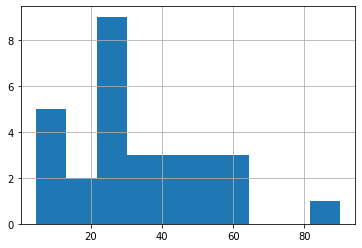

min     4.622800
max    90.053604
Name: Wire 9, dtype: float64
------------


In [44]:
for wire in df_wire.columns[df_wire.columns != 'key']:
    print(wire)
    df_wire[f'{wire}'].hist()
    plt.show()
    print(df_wire[f'{wire}'].agg(['min', 'max']))
    print('------------')

In [45]:
df_wire['key'].is_monotonic

True

В данных по проволокам аномалий не обнаружено.

#### Данные о проволочных материалах (время)

In [46]:
df_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [47]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [48]:
df_wire_time.agg(['min', 'max'])

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
min,1,2019-05-03 11:11:41,2019-05-03 13:32:06,2019-05-04 04:47:53,2019-05-07 08:48:23,2019-08-08 16:01:07,2019-05-07 08:37:20,2019-07-23 12:08:44,2019-05-14 00:03:32,2019-05-04 16:09:11
max,3241,2019-09-01 04:16:01,2019-08-31 18:50:15,2019-08-28 02:11:18,2019-08-08 12:03:12,2019-08-08 16:01:07,2019-08-14 00:59:11,2019-08-08 18:27:34,2019-08-11 15:09:29,2019-08-29 03:51:31


Выбросов в значениях времени не замечено.

In [49]:
df_wire_time.isna().isin(df_wire.isna()).sum()

key       3081
Wire 1    3081
Wire 2    3081
Wire 3    3081
Wire 4    3081
Wire 5    3081
Wire 6    3081
Wire 7    3081
Wire 8    3081
Wire 9    3081
dtype: int64

Данные по объему проволок и по их количеству совпадают.

## Объединение

In [50]:
df_bulk = df_bulk.merge(df_bulk_time, on='key', suffixes=('', '_time'))
df = df_gas.merge(df_bulk, on='key', how='left')
df_wire = df_wire.merge(df_wire_time, on='key', suffixes=('','_time'))
df = df.merge(df_wire, on='key', how='left')

In [51]:
df.head()

,key,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk 1_time,Bulk 2_time,Bulk 3_time,Bulk 4_time,Bulk 5_time,Bulk 6_time,Bulk 7_time,Bulk 8_time,Bulk 9_time,Bulk 10_time,Bulk 11_time,Bulk 12_time,Bulk 13_time,Bulk 14_time,Bulk 15_time,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 5_time,Wire 6_time,Wire 7_time,Wire 8_time,Wire 9_time
0,1,29.749986,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,12.555561,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,28.554793,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,18.841219,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,5.413692,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [52]:
df_arc['heat_time'] = df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']
df_arc.drop(['Конец нагрева дугой', 'Начало нагрева дугой'], axis=1, inplace=True)

Оставляю только фактическое время нагрева.

In [53]:
df_out = df_arc.set_index([df_arc.groupby('key').cumcount()+1, 
                       'key']).unstack(0)
df_out.columns = [f'{i}_{j}' for i, j in df_out.columns]
df_out = df_out.reset_index()

Расплющиваю датафрейм по ключам, выстраивая данные в ряд.

In [54]:
df_out.head()

,key,Активная мощность_1,Активная мощность_2,Активная мощность_3,Активная мощность_4,Активная мощность_5,Активная мощность_6,Активная мощность_7,Активная мощность_8,Активная мощность_9,Активная мощность_10,Активная мощность_11,Активная мощность_12,Активная мощность_13,Активная мощность_14,Активная мощность_15,Активная мощность_16,Реактивная мощность_1,Реактивная мощность_2,Реактивная мощность_3,Реактивная мощность_4,Реактивная мощность_5,Реактивная мощность_6,Реактивная мощность_7,Реактивная мощность_8,Реактивная мощность_9,Реактивная мощность_10,Реактивная мощность_11,Реактивная мощность_12,Реактивная мощность_13,Реактивная мощность_14,Реактивная мощность_15,Реактивная мощность_16,heat_time_1,heat_time_2,heat_time_3,heat_time_4,heat_time_5,heat_time_6,heat_time_7,heat_time_8,heat_time_9,heat_time_10,heat_time_11,heat_time_12,heat_time_13,heat_time_14,heat_time_15,heat_time_16
0,1,0.976059,0.805607,0.744363,1.659363,0.692755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.687084,0.520285,0.498805,1.062669,0.414397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:03:48,00:03:05,00:02:52,00:06:05,00:02:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,0.438063,1.296415,0.490377,0.827743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.283043,0.892914,0.305281,0.516874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:02:17,00:05:38,00:02:06,00:03:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,1.062053,0.484206,0.429355,0.299989,0.250280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.671494,0.312100,0.271774,0.187806,0.155901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:04:40,00:02:04,00:01:49,00:01:17,00:01:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,0.875313,0.425692,0.687289,1.220955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.614404,0.268482,0.422692,0.754719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:03:27,00:01:39,00:02:37,00:04:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,0.950026,0.508026,1.621665,0.267457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.690523,0.332352,1.047776,0.181992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:04:11,00:02:12,00:06:55,00:01:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [55]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   key                     3214 non-null   int64          
 1   Активная мощность_1     3214 non-null   float64        
 2   Активная мощность_2     3175 non-null   float64        
 3   Активная мощность_3     3001 non-null   float64        
 4   Активная мощность_4     2481 non-null   float64        
 5   Активная мощность_5     1589 non-null   float64        
 6   Активная мощность_6     830 non-null    float64        
 7   Активная мощность_7     340 non-null    float64        
 8   Активная мощность_8     135 non-null    float64        
 9   Активная мощность_9     51 non-null     float64        
 10  Активная мощность_10    23 non-null     float64        
 11  Активная мощность_11    14 non-null     float64        
 12  Активная мощность_12    9 non-null

In [56]:
last_temps = df_temp[df_temp['Время замера'].isin(df_temp.groupby('key')['Время замера'].last().to_frame()['Время замера'])]

Делаю датафрейм состоящий из последних значений температур.

In [57]:
filt = last_temps['key'][last_temps['Температура'].isna()]
temp = df_temp[~df_temp['key'].isin(filt)]

Делаю фильтр с ключами у которых последняя температура неизвестна и отфильтровываю датафрейм с температурами.

In [58]:
df_res = temp.groupby('key')['Время замера', 'Температура'].agg(['first', 'last']).reset_index()
df_res.head()

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


key        Время замера                     Температура        
                    first                last       first    last
0   1 2019-05-03 11:16:18 2019-05-03 11:30:39      1571.0  1613.0
1   2 2019-05-03 11:37:27 2019-05-03 11:59:12      1581.0  1602.0
2   3 2019-05-03 12:13:17 2019-05-03 12:34:57      1596.0  1599.0
3   4 2019-05-03 12:52:57 2019-05-03 12:59:25      1601.0  1625.0
4   5 2019-05-03 13:23:19 2019-05-03 13:36:01      1576.0  1602.0

In [59]:
df_res.columns=['key','Время замера first','Время замера last','Температура first','Температура last']
df = df_res.merge(df_out, on='key', how='left').merge(df, on='key', how='left')

In [60]:
df.head()

,key,Время замера first,Время замера last,Температура first,Температура last,Активная мощность_1,Активная мощность_2,Активная мощность_3,Активная мощность_4,Активная мощность_5,Активная мощность_6,Активная мощность_7,Активная мощность_8,Активная мощность_9,Активная мощность_10,Активная мощность_11,Активная мощность_12,Активная мощность_13,Активная мощность_14,Активная мощность_15,Активная мощность_16,Реактивная мощность_1,Реактивная мощность_2,Реактивная мощность_3,Реактивная мощность_4,Реактивная мощность_5,Реактивная мощность_6,Реактивная мощность_7,Реактивная мощность_8,Реактивная мощность_9,Реактивная мощность_10,Реактивная мощность_11,Реактивная мощность_12,Реактивная мощность_13,Реактивная мощность_14,Реактивная мощность_15,Реактивная мощность_16,heat_time_1,heat_time_2,heat_time_3,heat_time_4,heat_time_5,heat_time_6,heat_time_7,heat_time_8,heat_time_9,heat_time_10,heat_time_11,heat_time_12,heat_time_13,heat_time_14,heat_time_15,heat_time_16,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk 1_time,Bulk 2_time,Bulk 3_time,Bulk 4_time,Bulk 5_time,Bulk 6_time,Bulk 7_time,Bulk 8_time,Bulk 9_time,Bulk 10_time,Bulk 11_time,Bulk 12_time,Bulk 13_time,Bulk 14_time,Bulk 15_time,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 5_time,Wire 6_time,Wire 7_time,Wire 8_time,Wire 9_time
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,0.976059,0.805607,0.744363,1.659363,0.692755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.687084,0.520285,0.498805,1.062669,0.414397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:03:48,00:03:05,00:02:52,00:06:05,00:02:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,29.749986,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,0.438063,1.296415,0.490377,0.827743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.283043,0.892914,0.305281,0.516874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:02:17,00:05:38,00:02:06,00:03:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,12.555561,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,1.062053,0.484206,0.429355,0.299989,0.250280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.671494,0.312100,0.271774,0.187806,0.155901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:04:40,00:02:04,00:01:49,00:01:17,00:01:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,28.554793,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,0.875313,0.425692,0.687289,1.220955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.614404,0.268482,0.422692,0.754719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:03:27,00:01:39,00:02:37,00:04:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,18.841219,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,0.950026,0.508026,1.621665,0.267457,NaN,NaN,NaN,NaN,NaN,

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Columns: 102 entries, key to Wire 9_time
dtypes: datetime64[ns](26), float64(59), int64(1), timedelta64[ns](16)
memory usage: 1.9 MB


## Обработка данных

In [62]:
df.head()

,key,Время замера first,Время замера last,Температура first,Температура last,Активная мощность_1,Активная мощность_2,Активная мощность_3,Активная мощность_4,Активная мощность_5,Активная мощность_6,Активная мощность_7,Активная мощность_8,Активная мощность_9,Активная мощность_10,Активная мощность_11,Активная мощность_12,Активная мощность_13,Активная мощность_14,Активная мощность_15,Активная мощность_16,Реактивная мощность_1,Реактивная мощность_2,Реактивная мощность_3,Реактивная мощность_4,Реактивная мощность_5,Реактивная мощность_6,Реактивная мощность_7,Реактивная мощность_8,Реактивная мощность_9,Реактивная мощность_10,Реактивная мощность_11,Реактивная мощность_12,Реактивная мощность_13,Реактивная мощность_14,Реактивная мощность_15,Реактивная мощность_16,heat_time_1,heat_time_2,heat_time_3,heat_time_4,heat_time_5,heat_time_6,heat_time_7,heat_time_8,heat_time_9,heat_time_10,heat_time_11,heat_time_12,heat_time_13,heat_time_14,heat_time_15,heat_time_16,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk 1_time,Bulk 2_time,Bulk 3_time,Bulk 4_time,Bulk 5_time,Bulk 6_time,Bulk 7_time,Bulk 8_time,Bulk 9_time,Bulk 10_time,Bulk 11_time,Bulk 12_time,Bulk 13_time,Bulk 14_time,Bulk 15_time,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 5_time,Wire 6_time,Wire 7_time,Wire 8_time,Wire 9_time
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,0.976059,0.805607,0.744363,1.659363,0.692755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.687084,0.520285,0.498805,1.062669,0.414397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:03:48,00:03:05,00:02:52,00:06:05,00:02:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,29.749986,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,0.438063,1.296415,0.490377,0.827743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.283043,0.892914,0.305281,0.516874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:02:17,00:05:38,00:02:06,00:03:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,12.555561,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,1.062053,0.484206,0.429355,0.299989,0.250280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.671494,0.312100,0.271774,0.187806,0.155901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:04:40,00:02:04,00:01:49,00:01:17,00:01:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,28.554793,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,0.875313,0.425692,0.687289,1.220955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.614404,0.268482,0.422692,0.754719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:03:27,00:01:39,00:02:37,00:04:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,18.841219,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,0.950026,0.508026,1.621665,0.267457,NaN,NaN,NaN,NaN,NaN,

Первое время замера можно сделать относительным от последнего, это будет полезная фича, показывающая какой должна быть температура и за какое время относительно требуемой температуры.

In [63]:
df['first_temp_t'] = df['Время замера last'] - df['Время замера first']
df['first_temp_t'] = df['first_temp_t'].astype('timedelta64[s]').astype('float')
df.drop(['Время замера first', 'Время замера last'], axis=1, inplace=True)
df.head()

,key,Температура first,Температура last,Активная мощность_1,Активная мощность_2,Активная мощность_3,Активная мощность_4,Активная мощность_5,Активная мощность_6,Активная мощность_7,Активная мощность_8,Активная мощность_9,Активная мощность_10,Активная мощность_11,Активная мощность_12,Активная мощность_13,Активная мощность_14,Активная мощность_15,Активная мощность_16,Реактивная мощность_1,Реактивная мощность_2,Реактивная мощность_3,Реактивная мощность_4,Реактивная мощность_5,Реактивная мощность_6,Реактивная мощность_7,Реактивная мощность_8,Реактивная мощность_9,Реактивная мощность_10,Реактивная мощность_11,Реактивная мощность_12,Реактивная мощность_13,Реактивная мощность_14,Реактивная мощность_15,Реактивная мощность_16,heat_time_1,heat_time_2,heat_time_3,heat_time_4,heat_time_5,heat_time_6,heat_time_7,heat_time_8,heat_time_9,heat_time_10,heat_time_11,heat_time_12,heat_time_13,heat_time_14,heat_time_15,heat_time_16,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk 1_time,Bulk 2_time,Bulk 3_time,Bulk 4_time,Bulk 5_time,Bulk 6_time,Bulk 7_time,Bulk 8_time,Bulk 9_time,Bulk 10_time,Bulk 11_time,Bulk 12_time,Bulk 13_time,Bulk 14_time,Bulk 15_time,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 5_time,Wire 6_time,Wire 7_time,Wire 8_time,Wire 9_time,first_temp_t
0,1,1571.0,1613.0,0.976059,0.805607,0.744363,1.659363,0.692755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.687084,0.520285,0.498805,1.062669,0.414397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:03:48,00:03:05,00:02:52,00:06:05,00:02:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,29.749986,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,861.0
1,2,1581.0,1602.0,0.438063,1.296415,0.490377,0.827743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.283043,0.892914,0.305281,0.516874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:02:17,00:05:38,00:02:06,00:03:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,12.555561,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1305.0
2,3,1596.0,1599.0,1.062053,0.484206,0.429355,0.299989,0.250280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.671494,0.312100,0.271774,0.187806,0.155901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:04:40,00:02:04,00:01:49,00:01:17,00:01:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,28.554793,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1300.0
3,4,1601.0,1625.0,0.875313,0.425692,0.687289,1.220955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.614404,0.268482,0.422692,0.754719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:03:27,00:01:39,00:02:37,00:04:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,18.841219,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,388.0
4,5,1576.0,1602.0,0.950026,0.508026,1.621665,0.267457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.690523,0.332352,1.047776,0.181992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:04:11,00:02:12,00:06:55,00:01:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,5.

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Columns: 101 entries, key to first_temp_t
dtypes: datetime64[ns](24), float64(60), int64(1), timedelta64[ns](16)
memory usage: 1.9 MB


In [65]:
df[df.select_dtypes(include=['timedelta64[ns]']).columns] = df[df.select_dtypes(
    include=['timedelta64[ns]']).columns].astype('timedelta64[s]').astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Columns: 101 entries, key to first_temp_t
dtypes: datetime64[ns](24), float64(76), int64(1)
memory usage: 1.9 MB


Перевожу оставшееся в секунды.

In [66]:
df.head()

,key,Температура first,Температура last,Активная мощность_1,Активная мощность_2,Активная мощность_3,Активная мощность_4,Активная мощность_5,Активная мощность_6,Активная мощность_7,Активная мощность_8,Активная мощность_9,Активная мощность_10,Активная мощность_11,Активная мощность_12,Активная мощность_13,Активная мощность_14,Активная мощность_15,Активная мощность_16,Реактивная мощность_1,Реактивная мощность_2,Реактивная мощность_3,Реактивная мощность_4,Реактивная мощность_5,Реактивная мощность_6,Реактивная мощность_7,Реактивная мощность_8,Реактивная мощность_9,Реактивная мощность_10,Реактивная мощность_11,Реактивная мощность_12,Реактивная мощность_13,Реактивная мощность_14,Реактивная мощность_15,Реактивная мощность_16,heat_time_1,heat_time_2,heat_time_3,heat_time_4,heat_time_5,heat_time_6,heat_time_7,heat_time_8,heat_time_9,heat_time_10,heat_time_11,heat_time_12,heat_time_13,heat_time_14,heat_time_15,heat_time_16,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk 1_time,Bulk 2_time,Bulk 3_time,Bulk 4_time,Bulk 5_time,Bulk 6_time,Bulk 7_time,Bulk 8_time,Bulk 9_time,Bulk 10_time,Bulk 11_time,Bulk 12_time,Bulk 13_time,Bulk 14_time,Bulk 15_time,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 5_time,Wire 6_time,Wire 7_time,Wire 8_time,Wire 9_time,first_temp_t
0,1,1571.0,1613.0,0.976059,0.805607,0.744363,1.659363,0.692755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.687084,0.520285,0.498805,1.062669,0.414397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,228.0,185.0,172.0,365.0,148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.749986,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,861.0
1,2,1581.0,1602.0,0.438063,1.296415,0.490377,0.827743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.283043,0.892914,0.305281,0.516874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.0,338.0,126.0,210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.555561,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1305.0
2,3,1596.0,1599.0,1.062053,0.484206,0.429355,0.299989,0.250280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.671494,0.312100,0.271774,0.187806,0.155901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280.0,124.0,109.0,77.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.554793,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1300.0
3,4,1601.0,1625.0,0.875313,0.425692,0.687289,1.220955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.614404,0.268482,0.422692,0.754719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,99.0,157.0,278.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.841219,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,388.0
4,5,1576.0,1602.0,0.950026,0.508026,1.621665,0.267457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.690523,0.332352,1.047776,0.181992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,251.0,132.0,415.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.413692,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,15

In [67]:
list(df.columns)

['key',
 'Температура first',
 'Температура last',
 'Активная мощность_1',
 'Активная мощность_2',
 'Активная мощность_3',
 'Активная мощность_4',
 'Активная мощность_5',
 'Активная мощность_6',
 'Активная мощность_7',
 'Активная мощность_8',
 'Активная мощность_9',
 'Активная мощность_10',
 'Активная мощность_11',
 'Активная мощность_12',
 'Активная мощность_13',
 'Активная мощность_14',
 'Активная мощность_15',
 'Активная мощность_16',
 'Реактивная мощность_1',
 'Реактивная мощность_2',
 'Реактивная мощность_3',
 'Реактивная мощность_4',
 'Реактивная мощность_5',
 'Реактивная мощность_6',
 'Реактивная мощность_7',
 'Реактивная мощность_8',
 'Реактивная мощность_9',
 'Реактивная мощность_10',
 'Реактивная мощность_11',
 'Реактивная мощность_12',
 'Реактивная мощность_13',
 'Реактивная мощность_14',
 'Реактивная мощность_15',
 'Реактивная мощность_16',
 'heat_time_1',
 'heat_time_2',
 'heat_time_3',
 'heat_time_4',
 'heat_time_5',
 'heat_time_6',
 'heat_time_7',
 'heat_time_8',
 'heat_

In [68]:
act_p = ['Активная мощность_1', 'Активная мощность_2', 'Активная мощность_3', 'Активная мощность_4',
         'Активная мощность_5', 'Активная мощность_6', 'Активная мощность_7', 'Активная мощность_8',
         'Активная мощность_9', 'Активная мощность_10', 'Активная мощность_11', 'Активная мощность_12',
         'Активная мощность_13', 'Активная мощность_14', 'Активная мощность_15', 'Активная мощность_16']

In [69]:
react_p = ['Реактивная мощность_1', 'Реактивная мощность_2', 'Реактивная мощность_3', 'Реактивная мощность_4',
           'Реактивная мощность_5', 'Реактивная мощность_6', 'Реактивная мощность_7', 'Реактивная мощность_8',
           'Реактивная мощность_9', 'Реактивная мощность_10', 'Реактивная мощность_11', 'Реактивная мощность_12',
           'Реактивная мощность_13', 'Реактивная мощность_14', 'Реактивная мощность_15', 'Реактивная мощность_16']

In [70]:
heat = ['heat_time_1', 'heat_time_2', 'heat_time_3', 'heat_time_4', 'heat_time_5', 'heat_time_6', 'heat_time_7',
        'heat_time_8', 'heat_time_9', 'heat_time_10', 'heat_time_11', 'heat_time_12', 'heat_time_13',
        'heat_time_14', 'heat_time_15', 'heat_time_16']

In [71]:
bulk = ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10',
        'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']

In [72]:
wire = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']

In [73]:
df.drop(df.filter(regex='[0-9]_time',axis=1).head().columns, axis=1, inplace=True)

In [74]:
df['act_p_sum'] = df[act_p].sum(axis=1)
df['act_p_mean'] = df[act_p].mean(axis=1)
df['react_p_sum'] = df[react_p].sum(axis=1)
df['react_p_mean'] = df[react_p].mean(axis=1)
df['heat_time_sum'] = df[heat].sum(axis=1)
df['heat_time_mean'] = df[heat].mean(axis=1)
df['bulk_mean'] = df[bulk].mean(axis=1)
df['bulk_sum'] = df[bulk].sum(axis=1)
df['wire_mean'] = df[wire].mean(axis=1)
df['wire_sum'] = df[wire].sum(axis=1)

In [75]:
df.drop(heat, axis=1, inplace=True)
df.drop(act_p, axis=1, inplace=True)
df.drop(react_p, axis=1, inplace=True)
df.drop(bulk, axis=1, inplace=True)
df.drop(wire, axis=1, inplace=True)

Сагрегировал все признаки на среднее и сумму, снёс все значения времени, за исключением времени первого измерения.

## Обучение модели

In [76]:
x_col = list(filter(lambda x: (x != 'Температура last')&(x != 'key'), list(df.columns)))
y_col = 'Температура last'

Убрал key из фичей.

In [77]:
train, test = train_test_split(df, test_size=0.3, random_state=4)
len(test)+len(train) == len(df)

True

Делю на обучающую и тестовую выборку, проверяю, что правильно разбилось.

In [78]:
model = CatBoostRegressor(random_state=4, iterations=1000, verbose=500)

In [79]:
score = (cross_val_score(model, train[x_col], train[y_col], scoring='neg_mean_absolute_error', cv=4, n_jobs=-1))
score, score.mean()

(array([-5.6131956 , -6.55945166, -5.80964616, -6.28507132]),
 -6.0668411850235895)

Кросс-валидация на 4 фолда дает 6.0 среднее мае.

In [80]:
model.fit(train[x_col], train[y_col])

Learning rate set to 0.043043
0:	learn: 15.8163864	total: 177ms	remaining: 2m 56s
500:	learn: 4.8539311	total: 1.64s	remaining: 1.64s
999:	learn: 3.3348791	total: 3.01s	remaining: 0us


In [81]:
fi = pd.DataFrame(data = model.get_feature_importance(), index=x_col)

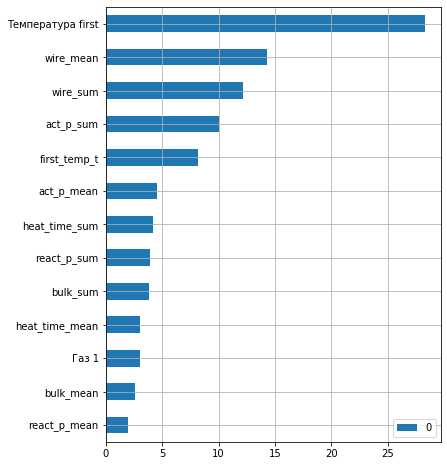

In [82]:
fi.sort_values(0, ascending=True).tail(15).plot(kind='barh', figsize=(6,8), grid=True)

Самый важный признак это первоначальная температура.

In [83]:
cb_score = mae(test[y_col], model.predict(test[x_col]))
cb_score

5.851886984042874

На тестовой выборке кэтбуст выдал 5.85 мае.

## Отчет

В процессе исследования были выполнены следующие задачи:
- данные загружены;
- проведен первичный анализ данных, данные проверены на пропуски и выбросы;
- данные объединены в одну таблицу:
     - таблицы агрегированы на среднее и медиану;
     - удалены ключи, не имеющие целевой признак.
- для предсказания использовался CatBoostRegressor:
    - данные разбиты на тестовую и тренировочную выборку 1 к 3;
    - на кросс-валидации модель показала 6.0 мае при 4 фолдах;
    - на тестовой выборке модель показала 5.78 мае.  

Все запланированные мероприятия выполнены.  
Единственная трудность, которая возникла, это разобраться, как растянуть данные, в которых которых повторялись ключи. Что в итоге не пригодилось, так как пришлось агрегировать).  
Табличка с тремя моделями внизу ноутбука.

## Приложение

Дополнительно рассмотрим еще две модели.

In [84]:
train_s = train.fillna(0)
test_s = test.fillna(0)

In [85]:
scaler = StandardScaler()
scaler.fit(train_s[x_col])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [86]:
train_s[x_col] = scaler.transform(train_s[x_col])
test_s[x_col] = scaler.transform(test_s[x_col])

In [87]:
model = RandomForestRegressor(random_state=4, criterion='mae', n_jobs=-1)
model.fit(train_s[x_col], train_s[y_col])
rf_score = mae(test_s[y_col] ,model.predict(test_s[x_col]))

In [88]:
model = XGBRegressor(random_state=4)
model.fit(train_s[x_col], train_s[y_col])
xgb_score = mae(test_s[y_col] ,model.predict(test_s[x_col]))

D:\Programs\Anaconda\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [89]:
{'catboost':cb_score,
'randomforest': rf_score,
'xgboost': xgb_score}

{'catboost': 5.851886984042874,
 'randomforest': 6.219395161290322,
 'xgboost': 6.327242287256384}